In [1]:
!pip install -q transformers datasets evaluate peft accelerate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


In [2]:
# Clone GitHub repo with financial phrasebank dataset
!git clone https://github.com/DanDmc/DSA4213_Assignment3_FinetuningBert.git

%cd DSA4213_Assignment3_FinetuningBert

from datasets import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
import time
from collections import defaultdict

import os, warnings
from transformers.utils.logging import set_verbosity_error
from sklearn.exceptions import UndefinedMetricWarning

os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"

set_verbosity_error()
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=SyntaxWarning)

Cloning into 'DSA4213_Assignment3_FinetuningBert'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 9), reused 14 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 1.05 MiB | 3.80 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/DSA4213_Assignment3_FinetuningBert


In [3]:
# set seed for reproducibility and helper functions for efficiency

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

def count_params(model):
    #Count total and trainable parameters
    tot = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return tot, trainable, trainable/tot if tot > 0 else 0

def get_memory_usage():
    #Get peak GPU memory usage in MB
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / 1e6
    return 0

def reset_memory():
    #Reset GPU memory tracking
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

# Storage for all results
all_results = []

In [4]:
from datasets import Dataset
import pandas as pd

def load_financial_phrasebank(path="data/Sentences_75Agree.txt"):
    # Load and parse data
    rows = []
    with open(path, "r", encoding="latin-1") as f:
        for line in f:
            line = line.strip()
            if "@" in line:
                sentence, label = line.rsplit("@", 1)
                rows.append((sentence.strip(), label.strip().lower()))

    df = pd.DataFrame(rows, columns=["sentence", "label"])
    label_map = {"negative": 0, "neutral": 1, "positive": 2}
    df["label"] = df["label"].map(label_map)

    # Convert to HuggingFace Dataset
    dataset = Dataset.from_pandas(df)

    # Split 80% train, 20% temp (val+test)
    split_1 = dataset.train_test_split(test_size=0.2, seed=42)
    train_dataset = split_1["train"]
    temp_dataset = split_1["test"]

    # Split temp into 10% val, 10% test
    split_2 = temp_dataset.train_test_split(test_size=0.5, seed=42)
    val_dataset = split_2["train"]
    test_dataset = split_2["test"]

    return {"train": train_dataset, "validation": val_dataset, "test": test_dataset}

dataset = load_financial_phrasebank()

In [5]:
# Keep original test sentences for error analysis
original_test_sentences = dataset["test"]["sentence"]

In [7]:
# some basic data summaries

train_df = dataset["train"].to_pandas()
val_df = dataset["validation"].to_pandas()
test_df = dataset["test"].to_pandas()

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
total_samples = len(train_df) + len(val_df) + len(test_df)
print(f"Total samples: {total_samples}")
print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")

# Function to print counts + percentages
def show_distribution(df, name):
    counts = df["label"].value_counts().sort_index()
    percentages = counts / len(df) * 100
    print(f"\nLabel distribution ({name}):")
    for label, count in counts.items():
        print(f"  {label}: {count} ({percentages[label]:.2f}%)")

show_distribution(train_df, "Train")
show_distribution(val_df, "Validation")
show_distribution(test_df, "Test")

# Combined distribution across all samples
all_labels = pd.concat([train_df["label"], val_df["label"], test_df["label"]])
counts_all = all_labels.value_counts().sort_index()
percentages_all = counts_all / len(all_labels) * 100
print("\nLabel distribution (Overall):")
for label, count in counts_all.items():
    print(f"  {label}: {count} ({percentages_all[label]:.2f}%)")

# Sample sentences
print("\n" + "="*60)
print("SAMPLE SENTENCES")
print("="*60)
label_names = ["Negative", "Neutral", "Positive"]
for i, label_name in enumerate(label_names):
    sample = train_df[train_df["label"] == i].iloc[0]["sentence"]
    print(f"{label_name}: {sample[:100]}...")


DATASET OVERVIEW
Total samples: 3453
Train size: 2762 | Val size: 345 | Test size: 346

Label distribution (Train):
  0: 329 (11.91%)
  1: 1708 (61.84%)
  2: 725 (26.25%)

Label distribution (Validation):
  0: 43 (12.46%)
  1: 220 (63.77%)
  2: 82 (23.77%)

Label distribution (Test):
  0: 48 (13.87%)
  1: 218 (63.01%)
  2: 80 (23.12%)

Label distribution (Overall):
  0: 420 (12.16%)
  1: 2146 (62.15%)
  2: 887 (25.69%)

SAMPLE SENTENCES
Negative: Finnish media company Talentum Oyj 's net profit decreased to 2.5 mln euro ( $ 4.0 mln ) for the fir...
Neutral: These include software development for internet and mobile telephone content , communications , valu...
Positive: Sanoma Magazines Finland 's net sales grew to EUR 140.1 mn from EUR 131.8 mn ....


In [7]:
#SETUP FOR EVALUATION METRICS

# Load standard Hugging Face metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

# Define compute_metrics function (used by Trainer during evaluation)
def compute_metrics_extended(eval_pred):
    logits, labels = eval_pred #raw output logits and true class labels
    preds = np.argmax(logits, axis=-1) #convert logits into discrete predicted class labels

    # macro shows if model performs evenly across all sentiments, weighted shows realistic performance on actual data distribution
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    f1_macro = f1_metric.compute(predictions=preds, references=labels, average="macro")
    f1_weighted = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    precision_macro = precision_metric.compute(predictions=preds, references=labels, average="macro")
    recall_macro = recall_metric.compute(predictions=preds, references=labels, average="macro")

    return {
        "accuracy": acc["accuracy"],
        "precision_macro": precision_macro["precision"],
        "recall_macro": recall_macro["recall"],
        "f1_macro": f1_macro["f1"],
        "f1_weighted": f1_weighted["f1"],
    }


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**BERT baseline & full fine-tuning**

In [8]:
# Storage for all results
all_results = []

In [9]:
#TOKENIZATION

MODEL_NAME_BASE = "bert-base-uncased"  # generic BERT as baseline
tokenizer_base = AutoTokenizer.from_pretrained(MODEL_NAME_BASE)

# Tokenize all three splits using the same tokenizer function
def tokenize_function_base(examples):
    return tokenizer_base(examples["sentence"], padding="max_length", truncation=True, max_length=128)

train_tokenized_bert = dataset["train"].map(tokenize_function_base, batched=True)
val_tokenized_bert = dataset["validation"].map(tokenize_function_base, batched=True)
test_tokenized_bert = dataset["test"].map(tokenize_function_base, batched=True)


# Tokenize all three splits using the same tokenizer function
def tokenize_function_base(examples):
    return tokenizer_base(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

#clean unecessary columns and set torch format
def prep_bert(ds):
    cols_to_remove = [c for c in ds.column_names if c not in ["input_ids", "attention_mask", "token_type_ids", "label"]]
    ds = ds.remove_columns(cols_to_remove)
    if "label" in ds.column_names:
        ds = ds.rename_column("label", "labels")
    ds.set_format("torch")
    return ds

train_tokenized_bert = prep_bert(train_tokenized_bert)
val_tokenized_bert = prep_bert(val_tokenized_bert)
test_tokenized_bert = prep_bert(test_tokenized_bert)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2762 [00:00<?, ? examples/s]

Map:   0%|          | 0/345 [00:00<?, ? examples/s]

Map:   0%|          | 0/346 [00:00<?, ? examples/s]

In [26]:
# EVALUATING ON BASELINE BERT MODEL

model_bert_zero = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_BASE, num_labels=3,
    id2label={0: "negative", 1: "neutral", 2: "positive"},
    label2id={"negative": 0, "neutral": 1, "positive": 2}
)

tot, train, ratio = count_params(model_bert_zero)
trainer_bert_zero = Trainer(model=model_bert_zero, compute_metrics=compute_metrics_extended)
eval_bert_zero = trainer_bert_zero.evaluate(test_tokenized_bert)


all_results.append({
    "model": "BERT-base (zero-shot)",
    "total_params": tot,
    "trainable_params": train,
    "trainable_ratio": ratio,
    "train_time_s": 0,
    "best_val_f1": 0,
    "test_accuracy": eval_bert_zero["eval_accuracy"],
    "test_f1_macro": eval_bert_zero["eval_f1_macro"],
    "peak_memory_mb": 0
})

{'eval_loss': 1.289879560470581, 'eval_model_preparation_time': 0.0026, 'eval_accuracy': 0.23121387283236994, 'eval_precision_macro': 0.07729468599033816, 'eval_recall_macro': 0.3333333333333333, 'eval_f1_macro': 0.12549019607843137, 'eval_f1_weighted': 0.0870452227133628, 'eval_runtime': 2.2673, 'eval_samples_per_second': 152.606, 'eval_steps_per_second': 19.407}


In [11]:
# FULL FINE_TUNING ON BERT MODEL
model_bert_ft = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_BASE, num_labels=3,
    id2label={0: "negative", 1: "neutral", 2: "positive"},
    label2id={"negative": 0, "neutral": 1, "positive": 2}
)

tot, train, ratio = count_params(model_bert_ft)

training_args_bert = TrainingArguments(
    output_dir="./results_bert_ft",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none",
    logging_steps=50,
    seed=42,
)

trainer_bert_ft = Trainer(
    model=model_bert_ft,
    args=training_args_bert,
    train_dataset=train_tokenized_bert,
    eval_dataset=val_tokenized_bert,
    compute_metrics=compute_metrics_extended,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

reset_memory()
start = time.time()
train_result = trainer_bert_ft.train()
train_time = time.time() - start
peak_mem = get_memory_usage()

# Get best validation score
best_val = max([log["eval_f1_macro"] for log in trainer_bert_ft.state.log_history if "eval_f1_macro" in log])
eval_bert_ft = trainer_bert_ft.evaluate(test_tokenized_bert)

all_results.append({
    "model": "BERT-base (full FT)",
    "total_params": tot,
    "trainable_params": train,
    "trainable_ratio": ratio,
    "train_time_s": train_time,
    "best_val_f1": best_val,
    "test_accuracy": eval_bert_ft["eval_accuracy"],
    "test_f1_macro": eval_bert_ft["eval_f1_macro"],
    "peak_memory_mb": peak_mem
})

{'loss': 0.8996, 'grad_norm': 9.528392791748047, 'learning_rate': 1.8583815028901734e-05, 'epoch': 0.28901734104046245}
{'loss': 0.5455, 'grad_norm': 17.649709701538086, 'learning_rate': 1.7138728323699423e-05, 'epoch': 0.5780346820809249}
{'loss': 0.3872, 'grad_norm': 5.761002540588379, 'learning_rate': 1.569364161849711e-05, 'epoch': 0.8670520231213873}
{'eval_loss': 0.2216440886259079, 'eval_accuracy': 0.927536231884058, 'eval_precision_macro': 0.8926699070689508, 'eval_recall_macro': 0.9043013802231045, 'eval_f1_macro': 0.8980623307087275, 'eval_f1_weighted': 0.928340974538483, 'eval_runtime': 2.5881, 'eval_samples_per_second': 133.305, 'eval_steps_per_second': 8.501, 'epoch': 1.0}
{'loss': 0.2345, 'grad_norm': 1.4116021394729614, 'learning_rate': 1.4248554913294798e-05, 'epoch': 1.1560693641618498}
{'loss': 0.1678, 'grad_norm': 5.226587772369385, 'learning_rate': 1.2803468208092486e-05, 'epoch': 1.4450867052023122}
{'loss': 0.1708, 'grad_norm': 1.1039979457855225, 'learning_rate':

**FinBERT baseline, full fine-tuning and LoRA**

In [12]:
# verify FinBERT original sentiment label order

from transformers import AutoConfig

finbert_config = AutoConfig.from_pretrained("ProsusAI/finbert")
print("FinBERT original id2label mapping:", finbert_config.id2label)


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

FinBERT original id2label mapping: {0: 'positive', 1: 'negative', 2: 'neutral'}


In [13]:
# Remap dataset to match FinBERT (current dataset is 0=negative, 1=neutral, 2=positive) and tokenize

MODEL_NAME_FINBERT = "ProsusAI/finbert"
tokenizer_finbert = AutoTokenizer.from_pretrained(MODEL_NAME_FINBERT)

# Remap labels to match FinBERT's original order (0=positive, 1=negative, 2=neutral)
def remap_labels(example):
    mapping = {0: 1, 1: 2, 2: 0}  # negative→1, neutral→2, positive→0
    example["label"] = mapping[example["label"]]
    return example

train_ds_fb = dataset["train"].map(remap_labels)
val_ds_fb = dataset["validation"].map(remap_labels)
test_ds_fb = dataset["test"].map(remap_labels)

def tokenize_function_finbert(examples):
    return tokenizer_finbert(examples["sentence"], padding="max_length", truncation=True, max_length=128)

def prep_finbert(ds):
    ds = ds.remove_columns(["sentence"])
    ds = ds.rename_column("label", "labels")
    ds.set_format("torch")
    return ds

train_tok_fb = prep_finbert(train_ds_fb.map(tokenize_function_finbert, batched=True))
val_tok_fb = prep_finbert(val_ds_fb.map(tokenize_function_finbert, batched=True))
test_tok_fb = prep_finbert(test_ds_fb.map(tokenize_function_finbert, batched=True))

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/2762 [00:00<?, ? examples/s]

Map:   0%|          | 0/345 [00:00<?, ? examples/s]

Map:   0%|          | 0/346 [00:00<?, ? examples/s]

Map:   0%|          | 0/2762 [00:00<?, ? examples/s]

Map:   0%|          | 0/345 [00:00<?, ? examples/s]

Map:   0%|          | 0/346 [00:00<?, ? examples/s]

In [14]:
# EVALUATE BASELINE FinBERT

model_fb_baseline = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_FINBERT, num_labels=3,
    id2label={0: "positive", 1: "negative", 2: "neutral"},
    label2id={"positive": 0, "negative": 1, "neutral": 2}
)

tot, train, ratio = count_params(model_fb_baseline)
trainer_fb_baseline = Trainer(model=model_fb_baseline, compute_metrics=compute_metrics_extended)
eval_fb_baseline = trainer_fb_baseline.evaluate(test_tok_fb)

all_results.append({
    "model": "FinBERT (baseline)",
    "total_params": tot,
    "trainable_params": train,
    "trainable_ratio": ratio,
    "train_time_s": 0,
    "best_val_f1": 0,
    "test_accuracy": eval_fb_baseline["eval_accuracy"],
    "test_f1_macro": eval_fb_baseline["eval_f1_macro"],
    "peak_memory_mb": 0
})

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

{'eval_loss': 0.1949954628944397, 'eval_model_preparation_time': 0.0026, 'eval_accuracy': 0.9508670520231214, 'eval_precision_macro': 0.9210478906654914, 'eval_recall_macro': 0.9634556574923548, 'eval_f1_macro': 0.940099380951059, 'eval_f1_weighted': 0.9514878660534639, 'eval_runtime': 2.5441, 'eval_samples_per_second': 135.999, 'eval_steps_per_second': 17.295}


In [15]:
# FinBERT full fine-tuning

model_fb_ft = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_FINBERT, num_labels=3,
    id2label={0: "positive", 1: "negative", 2: "neutral"},
    label2id={"positive": 0, "negative": 1, "neutral": 2}
)

tot, train, ratio = count_params(model_fb_ft)

training_args_fb = TrainingArguments(
    output_dir="./results_finbert_ft",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none",
    logging_steps=50,
    seed=42,
)

trainer_fb_ft = Trainer(
    model=model_fb_ft,
    args=training_args_fb,
    train_dataset=train_tok_fb,
    eval_dataset=val_tok_fb,
    compute_metrics=compute_metrics_extended,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

reset_memory()
start = time.time()
trainer_fb_ft.train()
train_time_ft = time.time() - start
peak_mem_ft = get_memory_usage()

best_val_ft = max([log["eval_f1_macro"] for log in trainer_fb_ft.state.log_history if "eval_f1_macro" in log])
eval_fb_ft = trainer_fb_ft.evaluate(test_tok_fb)

all_results.append({
    "model": "FinBERT (full FT)",
    "total_params": tot,
    "trainable_params": train,
    "trainable_ratio": ratio,
    "train_time_s": train_time_ft,
    "best_val_f1": best_val_ft,
    "test_accuracy": eval_fb_ft["eval_accuracy"],
    "test_f1_macro": eval_fb_ft["eval_f1_macro"],
    "peak_memory_mb": peak_mem_ft
})

# Store predictions for confusion matrix
pred_fb_ft = trainer_fb_ft.predict(test_tok_fb)
y_true_ft = pred_fb_ft.label_ids
y_pred_ft = np.argmax(pred_fb_ft.predictions, axis=1)


{'loss': 0.1845, 'grad_norm': 14.178747177124023, 'learning_rate': 1.8583815028901734e-05, 'epoch': 0.28901734104046245}
{'loss': 0.1617, 'grad_norm': 13.641468048095703, 'learning_rate': 1.7138728323699423e-05, 'epoch': 0.5780346820809249}
{'loss': 0.1663, 'grad_norm': 10.32669734954834, 'learning_rate': 1.569364161849711e-05, 'epoch': 0.8670520231213873}
{'eval_loss': 0.13913078606128693, 'eval_accuracy': 0.9565217391304348, 'eval_precision_macro': 0.9276753189634599, 'eval_recall_macro': 0.9534625895941834, 'eval_f1_macro': 0.9397471273158171, 'eval_f1_weighted': 0.9571049452226217, 'eval_runtime': 2.5396, 'eval_samples_per_second': 135.846, 'eval_steps_per_second': 8.663, 'epoch': 1.0}
{'loss': 0.0926, 'grad_norm': 1.186824083328247, 'learning_rate': 1.4248554913294798e-05, 'epoch': 1.1560693641618498}
{'loss': 0.0678, 'grad_norm': 20.615922927856445, 'learning_rate': 1.2803468208092486e-05, 'epoch': 1.4450867052023122}
{'loss': 0.0414, 'grad_norm': 0.06933917105197906, 'learning_r

In [16]:
# FinBERT + LoRA Fine-tuning, with rank ablations

from peft import LoraConfig, get_peft_model, TaskType
lora_ranks = [4, 8, 16] #for ablations
lora_results = {}

for rank in lora_ranks:
    print(f"\n[3.{lora_ranks.index(rank)+1}] FinBERT + LoRA (r={rank})")

    model_lora = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME_FINBERT, num_labels=3,
        id2label={0: "positive", 1: "negative", 2: "neutral"},
        label2id={"positive": 0, "negative": 1, "neutral": 2}
    )

    lora_config = LoraConfig(
        r=rank,
        lora_alpha=16,
        target_modules=["query", "value"],
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.SEQ_CLS
    )

    model_lora = get_peft_model(model_lora, lora_config)
    tot, train, ratio = count_params(model_lora)

    print(f"Trainable: {train:,} ({ratio*100:.2f}%)")

    training_args_lora = TrainingArguments(
        output_dir=f"./results_finbert_lora_r{rank}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=4,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        report_to="none",
        logging_steps=50,
        seed=42,
    )

    trainer_lora = Trainer(
        model=model_lora,
        args=training_args_lora,
        train_dataset=train_tok_fb,
        eval_dataset=val_tok_fb,
        compute_metrics=compute_metrics_extended,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    reset_memory()
    start = time.time()
    trainer_lora.train()
    train_time_lora = time.time() - start
    peak_mem_lora = get_memory_usage()

    best_val_lora = max([log["eval_f1_macro"] for log in trainer_lora.state.log_history if "eval_f1_macro" in log])
    eval_lora = trainer_lora.evaluate(test_tok_fb)

    all_results.append({
        "model": f"FinBERT LoRA r={rank}",
        "total_params": tot,
        "trainable_params": train,
        "trainable_ratio": ratio,
        "train_time_s": train_time_lora,
        "best_val_f1": best_val_lora,
        "test_accuracy": eval_lora["eval_accuracy"],
        "test_f1_macro": eval_lora["eval_f1_macro"],
        "peak_memory_mb": peak_mem_lora
    })

    # Store for comparison
    lora_results[rank] = {
        "trainer": trainer_lora,
        "predictions": trainer_lora.predict(test_tok_fb)
    }

# Store r=8 predictions for confusion matrix
y_true_lora = lora_results[8]["predictions"].label_ids
y_pred_lora = np.argmax(lora_results[8]["predictions"].predictions, axis=1)


[3.1] FinBERT + LoRA (r=4)
Trainable: 149,763 (0.14%)
{'loss': 0.1816, 'grad_norm': 2.1665902137756348, 'learning_rate': 1.8583815028901734e-05, 'epoch': 0.28901734104046245}
{'loss': 0.1541, 'grad_norm': 0.9594961404800415, 'learning_rate': 1.7138728323699423e-05, 'epoch': 0.5780346820809249}
{'loss': 0.1488, 'grad_norm': 2.344684362411499, 'learning_rate': 1.569364161849711e-05, 'epoch': 0.8670520231213873}
{'eval_loss': 0.10458588600158691, 'eval_accuracy': 0.9710144927536232, 'eval_precision_macro': 0.9451591621309583, 'eval_recall_macro': 0.9760618092438852, 'eval_f1_macro': 0.959700176366843, 'eval_f1_weighted': 0.9713932980599648, 'eval_runtime': 2.5462, 'eval_samples_per_second': 135.497, 'eval_steps_per_second': 8.64, 'epoch': 1.0}
{'loss': 0.144, 'grad_norm': 1.9329358339309692, 'learning_rate': 1.4248554913294798e-05, 'epoch': 1.1560693641618498}
{'loss': 0.1356, 'grad_norm': 1.9045038223266602, 'learning_rate': 1.2803468208092486e-05, 'epoch': 1.4450867052023122}
{'loss': 

**RESULTS ANALYSIS**

In [28]:
# table for important metrics across models including efficiency
print("\n" + "="*70)
print("TABLE 1: PERFORMANCE VS COST")
print("="*70)

results_df = pd.DataFrame(all_results)
results_df = results_df[[
    "model", "trainable_params", "trainable_ratio", "train_time_s",
    "best_val_f1", "test_accuracy", "test_f1_macro", "peak_memory_mb"
]]

# Format for display
display_df = results_df.copy()
display_df["trainable_ratio"] = display_df["trainable_ratio"].apply(lambda x: f"{x*100:.2f}%")
display_df["trainable_params"] = display_df["trainable_params"].apply(lambda x: f"{x:,}")
display_df["train_time_s"] = display_df["train_time_s"].apply(lambda x: f"{x:.1f}")
display_df["best_val_f1"] = display_df["best_val_f1"].apply(lambda x: f"{x:.4f}" if x > 0 else "N/A")
display_df["test_accuracy"] = display_df["test_accuracy"].apply(lambda x: f"{x:.4f}")
display_df["test_f1_macro"] = display_df["test_f1_macro"].apply(lambda x: f"{x:.4f}")
display_df["peak_memory_mb"] = display_df["peak_memory_mb"].apply(lambda x: f"{x:.1f}" if x > 0 else "N/A")

print(display_df.to_string(index=False))

# Save to CSV
results_df.to_csv("efficiency_table.csv", index=False)
print("\n✓ Saved to: efficiency_table.csv")


TABLE 1: PERFORMANCE VS COST
                model trainable_params trainable_ratio train_time_s best_val_f1 test_accuracy test_f1_macro peak_memory_mb
BERT-base (zero-shot)      109,484,547         100.00%          0.0         N/A        0.2312        0.1255            N/A
  BERT-base (full FT)      109,484,547         100.00%        370.5      0.9237        0.9191        0.9002         3093.3
   FinBERT (baseline)      109,484,547         100.00%          0.0         N/A        0.9509        0.9401            N/A
    FinBERT (full FT)      109,484,547         100.00%        465.7      0.9613        0.9509        0.9400         4846.1
     FinBERT LoRA r=4          149,763           0.14%        129.9      0.9597        0.9566        0.9445         5023.0
     FinBERT LoRA r=8          297,219           0.27%        179.4      0.9613        0.9595        0.9474         5466.5
    FinBERT LoRA r=16          592,131           0.54%        180.0      0.9613        0.9566        0.9445  

In [1]:
from transformers import AutoModelForSequenceClassification

bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)

sum(p.numel() for p in bert_model.parameters()), sum(p.numel() for p in finbert_model.parameters())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

(109484547, 109484547)


CONFUSION MATRICES
✓ Saved: confusion_matrices.png


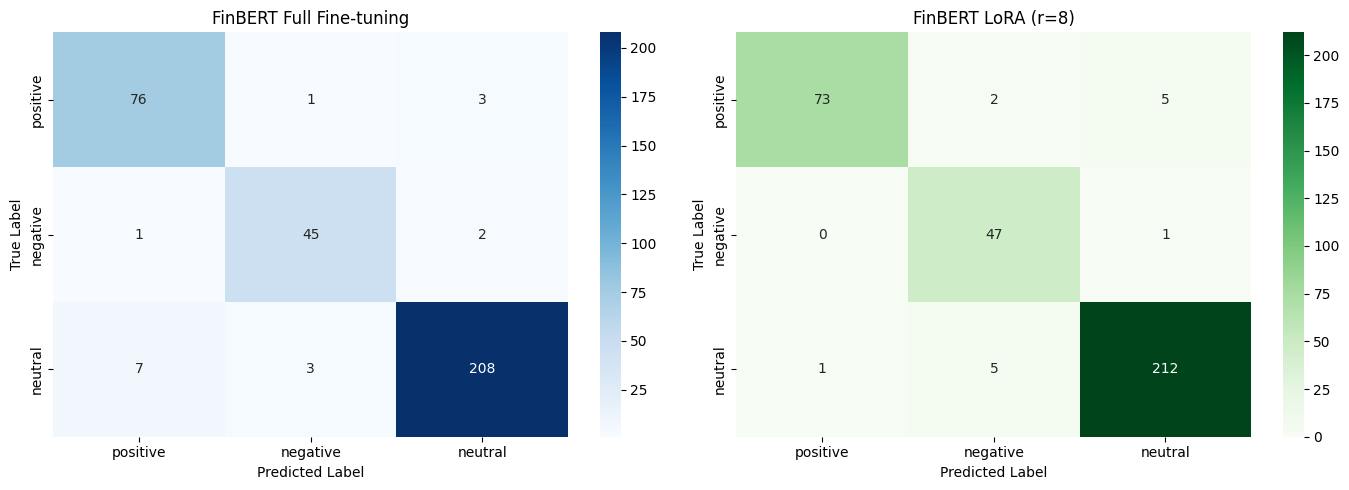

In [29]:
# confusion matrices comparing FinBERT full fine-tiune vs FinBERT LoRA (r=8)
print("\n" + "="*70)
print("CONFUSION MATRICES")
print("="*70)

label_names = ["positive", "negative", "neutral"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# FinBERT Full FT
cm_ft = confusion_matrix(y_true_ft, y_pred_ft)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=label_names, yticklabels=label_names)
axes[0].set_title('FinBERT Full Fine-tuning')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# FinBERT LoRA r=8
cm_lora = confusion_matrix(y_true_lora, y_pred_lora)
sns.heatmap(cm_lora, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=label_names, yticklabels=label_names)
axes[1].set_title('FinBERT LoRA (r=8)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
print("✓ Saved: confusion_matrices.png")
plt.show()

In [19]:
#per-class metrics for FinBERT full fine-tune and LoRA (r=8)
print("\n" + "="*70)
print("PER-CLASS CLASSIFICATION REPORTS")
print("="*70)

print("\n--- FinBERT Full Fine-tuning ---")
print(classification_report(y_true_ft, y_pred_ft, target_names=label_names, digits=4))

print("\n--- FinBERT LoRA (r=8) ---")
print(classification_report(y_true_lora, y_pred_lora, target_names=label_names, digits=4))


PER-CLASS CLASSIFICATION REPORTS

--- FinBERT Full Fine-tuning ---
              precision    recall  f1-score   support

    positive     0.9048    0.9500    0.9268        80
    negative     0.9184    0.9375    0.9278        48
     neutral     0.9765    0.9541    0.9652       218

    accuracy                         0.9509       346
   macro avg     0.9332    0.9472    0.9400       346
weighted avg     0.9519    0.9509    0.9511       346


--- FinBERT LoRA (r=8) ---
              precision    recall  f1-score   support

    positive     0.9865    0.9125    0.9481        80
    negative     0.8704    0.9792    0.9216        48
     neutral     0.9725    0.9725    0.9725       218

    accuracy                         0.9595       346
   macro avg     0.9431    0.9547    0.9474       346
weighted avg     0.9616    0.9595    0.9598       346



**ERROR ANALYSIS**

In [46]:
print("\n" + "="*70)
print("ERROR ANALYSIS: Where LoRA ≠ Full FT")
print("="*70)

# Find disagreements between FinBERT full fine-tune and LoRA (r=8)
disagreements = np.where(y_pred_ft != y_pred_lora)[0]

print(f"\nTotal disagreements: {len(disagreements)} out of {len(y_true_ft)} test samples")
print(f"Agreement rate: {(1 - len(disagreements)/len(y_true_ft))*100:.2f}%\n")

#trying to investgate errors with tags
import re
NEG   = re.compile(r"\b(no|not|without|decline|drop|loss|fell|lower)\b", re.I)
HEDGE = re.compile(r"\b(may|might|could|uncertain|likely|possibly)\b", re.I)
COMP  = re.compile(r"\b(less|more|smaller|larger|than|vs\.|compared)\b", re.I)
TURN  = re.compile(r"\b(but|however|although|yet)\b", re.I)
NUMERIC = re.compile(r"\b(\d+(\.\d+)?%|\d+\s*(mn|bn|million|billion|EUR|USD|£|\$))\b", re.I)


def tags(text):
    t=[]
    if NEG.search(text): t.append("negation")
    if HEDGE.search(text): t.append("hedging")
    if COMP.search(text): t.append("comparative")
    if TURN.search(text): t.append("contrast")
    if NUMERIC.search(text): t.append("quantiative")
    return t or ["none"]

# Show first 10 representative errors for qualtiative analysis
print("Sample disagreements:\n")
for idx in disagreements[:10]:
    i = int(idx)  # 👈 convert numpy.int64 → int
    text = original_test_sentences[i]
    tl = ", ".join(tags(text))
    print(f"[{i}] tags: {tl}")
    print(text[:220], "...\n",
          f"True={label_names[y_true_ft[i]]} | FT={label_names[y_pred_ft[i]]} | LoRA={label_names[y_pred_lora[i]]}\n")


ERROR ANALYSIS: Where LoRA ≠ Full FT

Total disagreements: 16 out of 346 test samples
Agreement rate: 95.38%

Sample disagreements:

[4] tags: none
F-Secure reported that : - The first half of 2008 has seen a growing number of targeted malware attacks on individuals , companies , and organizations . ...
 True=neutral | FT=neutral | LoRA=negative

[32] tags: negation, comparative, quantiative
The loss for the third quarter of 2007 was EUR 0.3 mn smaller than the loss of the second quarter of 2007 . ...
 True=positive | FT=positive | LoRA=negative

[45] tags: quantiative
The Baltimore Police and Fire Pension , which has about $ 1.5 billion , lost about $ 3.5 million in Madoff Ponzi scheme . ...
 True=negative | FT=neutral | LoRA=negative

[54] tags: quantiative
Sampo Housing Loan Bank , a unit of Finland 's Sampo Bank , has priced its EUR1bn ( USD1 .3 bn ) bond at 99.889 % , Reuters reported . ...
 True=neutral | FT=positive | LoRA=neutral

[57] tags: none
While I cant understand what t

**LoRA Rank Ablations Analysis**


LORA RANK SWEEP: F1 vs Efficiency
✓ Saved: lora_rank_sweep.png


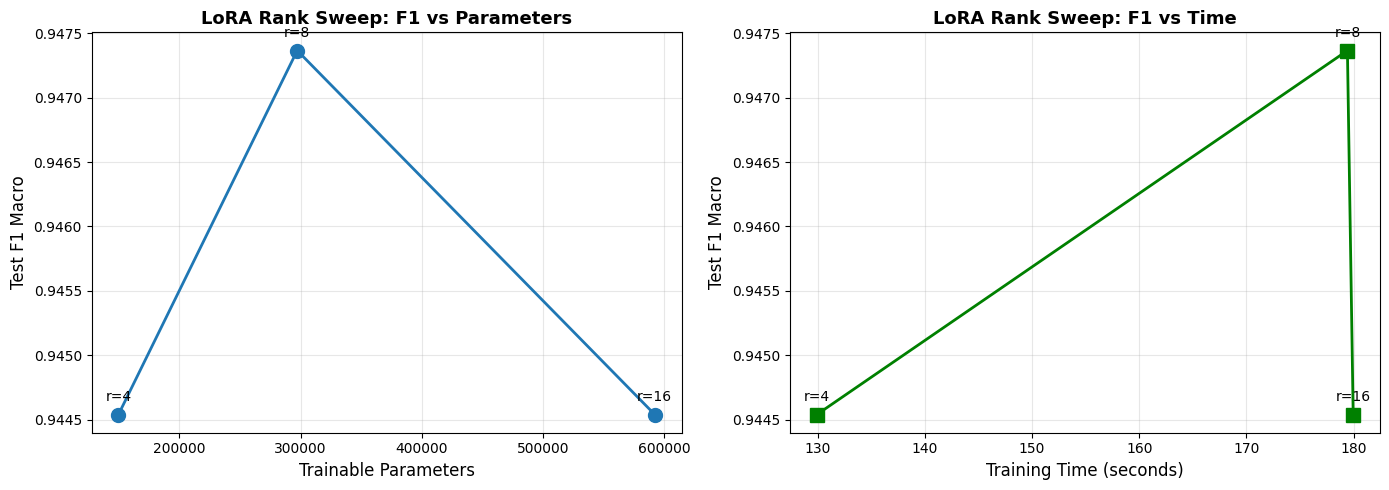

In [31]:
# to investigate F1 vs efficiency trade-offs

print("\n" + "="*70)
print("LORA RANK SWEEP: F1 vs Efficiency")
print("="*70)

lora_df = results_df[results_df["model"].str.contains("LoRA")].copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# F1 vs Trainable Params
ax1.plot(lora_df["trainable_params"], lora_df["test_f1_macro"], 'o-', markersize=10, linewidth=2)
ax1.set_xlabel('Trainable Parameters', fontsize=12)
ax1.set_ylabel('Test F1 Macro', fontsize=12)
ax1.set_title('LoRA Rank Sweep: F1 vs Parameters', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
for i, row in lora_df.iterrows():
    rank = row["model"].split("=")[-1]
    ax1.annotate(f'r={rank}', (row["trainable_params"], row["test_f1_macro"]),
                 textcoords="offset points", xytext=(0,10), ha='center')

# F1 vs Training Time
ax2.plot(lora_df["train_time_s"], lora_df["test_f1_macro"], 's-', markersize=10, linewidth=2, color='green')
ax2.set_xlabel('Training Time (seconds)', fontsize=12)
ax2.set_ylabel('Test F1 Macro', fontsize=12)
ax2.set_title('LoRA Rank Sweep: F1 vs Time', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
for i, row in lora_df.iterrows():
    rank = row["model"].split("=")[-1]
    ax2.annotate(f'r={rank}', (row["train_time_s"], row["test_f1_macro"]),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.savefig('lora_rank_sweep.png', dpi=300, bbox_inches='tight')
print("✓ Saved: lora_rank_sweep.png")
plt.show()

**Additional Investigation
**

In [ ]:
# statistical significance check between FinBERT full fine-tune vs FinBERT LoRA (r=8)
import numpy as np

def f1_macro(ytrue, ypred, n=3):
    f1s=[]
    for c in range(n):
        tp = ((ytrue==c)&(ypred==c)).sum()
        fp = ((ytrue!=c)&(ypred==c)).sum()
        fn = ((ytrue==c)&(ypred!=c)).sum()
        p  = tp/(tp+fp+1e-12); r = tp/(tp+fn+1e-12)
        f1s.append(2*p*r/(p+r+1e-12))
    return float(np.mean(f1s))

y = y_true_ft
yhat_ft = y_pred_ft
yhat_l8 = np.argmax(lora_results[8]["predictions"].predictions, axis=1)

# Bootstrap CI for ΔF1
rng = np.random.default_rng(42)
B=3000; idx=np.arange(len(y))
diffs=[f1_macro(y[b], yhat_l8[b]) - f1_macro(y[b], yhat_ft[b]) for b in (rng.choice(idx, len(idx), True) for _ in range(B))]
ci = np.percentile(diffs,[2.5,97.5]); print(f"ΔF1 mean={np.mean(diffs):.4f}, 95%CI={ci}")

# McNemar
ft_wrong   = (yhat_ft!=y)
l8_wrong   = (yhat_l8!=y)
b = np.sum( ft_wrong & ~l8_wrong)   # FT wrong, LoRA right
c = np.sum(~ft_wrong &  l8_wrong)   # FT right, LoRA wrong
chi2 = (abs(b-c)-1)**2/(b+c+1e-12)  # Edwards correction
print(f"McNemar b={b}, c={c}, chi2≈{chi2:.3f} (df=1)")

ΔF1 mean=0.0078, 95%CI=[-0.02074741  0.03416488]
McNemar b=9, c=6, chi2≈0.267 (df=1)
